In [97]:
import xarray
import cartopy
import matplotlib.pyplot as mp
import numpy
import pandas
import calendar
import datetime
import itertools
import scipy.signal
import cmocean
import netCDF4
import glob

In [98]:
#gpcp_monthly_filename = '/Users/baird/Dropbox/_data_observations/GPCP/precip.mon.mean.nc'
trmm_daily_directory = '/beegfs/DATA/pritchard/blangenb/TRMM_DATA/'

In [99]:
lat_lo = -25
lat_hi = 25
lon_lo = 85
lon_hi = 160

In [100]:
file_list = sorted(glob.glob(trmm_daily_directory+'/'+'*1998*nc4'))
ds_list = [netCDF4.Dataset(file) for file in file_list]

In [101]:
lat = numpy.array(ds_list[0]['lat'])
lon = numpy.array(ds_list[0]['lon'])

lat_indices = (lat>=lat_lo) & (lat<=lat_hi)
lon_indices = (lon>=lon_lo) & (lon<=lon_hi)

In [102]:
trmm_data = [numpy.array(i['precipitation'])[lon_indices,:][:,lat_indices] for i in ds_list]

In [103]:
file_list_ALL = numpy.array(sorted(glob.glob(trmm_daily_directory+'/'+'*nc4')))
trmm_datetime = numpy.array([datetime.datetime.strptime(f.split('/')[-1].split('.')[1], '%Y%m%d') for f in file_list_ALL])

go through each file, pull out precip, append to list  
convert list to array, set all negatives to NaN, and save it

In [104]:
trmm_data = numpy.load('trmm_indo_cropped_data.npy')
trmm_datetime = numpy.load('trmm_datetime_data.npy')
#lat_cropped = numpy.load('trmm_indo_cropped_lat.npy')
#lon_cropped = numpy.load('trmm_indo_cropped_lon.npy')

In [105]:
nino34_filename = '/beegfs/DATA/pritchard/blangenb/NINO34_INDEX/nino34_index.txt'
nino34_df = pandas.read_csv(nino34_filename, skiprows=1, skipfooter=3, header=None, delim_whitespace=True)
nino34_data = nino34_df.values[:,1:].flatten()
nino34_data[nino34_data==-99.99]=numpy.nan

/export/home/blangenb/miniconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skipfooter; you can avoid this warning by specifying engine='python'.
  


In [106]:
year_start = nino34_df[0].values[0]
year_end = nino34_df[0].values[-1]

nino34_datetime_list = []
for y,m in list(itertools.product(range(year_start,year_end+1),range(1,13))):
    nino34_datetime_list.append(datetime.date(y,m,15))
nino34_datetimes = numpy.array(nino34_datetime_list)

In [107]:
nino34_data_NaNs = numpy.zeros((nino34_data.shape), dtype=bool)
nino34_data_NaNs[~numpy.isnan(nino34_data)]=1
nino34_data_filtered = nino34_data[nino34_data_NaNs]
nino34_datetimes_filtered = nino34_datetimes[nino34_data_NaNs]

In [108]:
nino34_data_detrend = scipy.signal.detrend(nino34_data_filtered)
nino34_data_centered = nino34_data_detrend-nino34_data_detrend.mean()

### Definition of El Nino/La Nina:

The index is defined as a three-month average of sea surface temperature departures from normal for a critical region of the equatorial Pacific (Niño 3.4 region; 120W-170W, 5N-5S). This region of the tropical Pacific contains what scientists call the "equatorial cold tongue," a band of cool water that extends along the equator from the coast of South America to the central Pacific Ocean. Departures from average sea surface temperatures in this region are critically important in determining major shifts in the pattern of tropical rainfall, which influence the jet streams and patterns of temperature and precipitation around the world.

North America's operational definitions for El Niño and La Niña, based on the index, are:
El Niño: A phenomenon in the equatorial Pacific Ocean characterized by a positive sea surface temperature departure from normal (for the 1971-2000 base period) in the Niño 3.4 region greater than or equal in magnitude to 0.5 degrees C (0.9 degrees Fahrenheit), averaged over three consecutive months.

La Niña: A phenomenon in the equatorial Pacific Ocean characterized by a negative sea surface temperature departure from normal (for the 1971-2000 base period) in the Niño 3.4 region greater than or equal in magnitude to 0.5 degrees C (0.9 degrees Fahrenheit), averaged over three consecutive months.

In [109]:
nino34_data_final = pandas.Series(nino34_data_centered).rolling(window=3, center=True).mean()

plot

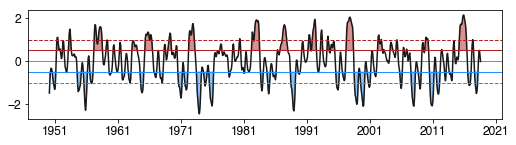

In [110]:
fontsize = 12

fig = mp.figure(figsize=(8.5,2))

x = nino34_datetimes_filtered
y2 = nino34_data_final

ax = fig.add_subplot(111)
ax.plot(x, y2, c='0.1')

ax.axhline(0, lw=0.5, ls='-', c='0.1')
ax.axhline(0.5, lw=1, ls='-', c='firebrick')
ax.axhline(-0.5, lw=1, ls='-', c='dodgerblue')

ax.axhline(1, lw=1, ls='--', c='firebrick')
ax.axhline(-1, lw=1, ls='--', c='dodgerblue')

y1_positive = numpy.ones((nino34_data_final.size))*0.5
y1_negative = numpy.ones((nino34_data_final.size))*-0.5

ax.fill_between(x, y1_positive, y2, where=y2>=y1_positive, color='firebrick', alpha='0.5')
ax.fill_between(x, y1_negative, y2, where=y2<=y1_negative, color='dodgerblue', alpha='0.5')

ax.tick_params(labelsize=fontsize)

define weak el nino as >=0.5 and <1.0  
strong el nino as >= 1.0

In [111]:
elnino_weak = (nino34_data_final>0.5) & (nino34_data_final<=1.0)
elnino_strong = (nino34_data_final>1.0)

lanina_weak = (nino34_data_final<-0.5) & (nino34_data_final>=-1.0)
lanina_strong = (nino34_data_final<-1.0)

elnino_all = (nino34_data_final>0.5)
lanina_all = (nino34_data_final<-0.5)

enso_neutral = (nino34_data_final>-0.5)&(nino34_data_final<0.5)

For a given index, pick out precip data when it's Aug, Sept, Oct AND corresponds to the index, then take stdev

In [112]:
lanina_all_dates = nino34_datetimes_filtered[lanina_all]
elnino_all_dates = nino34_datetimes_filtered[elnino_all]

In [113]:
# calculate el nino indices
trmm_dt_elnino_indices = []
date_tuples = [(t.year,t.month) for t in elnino_all_dates]
for t in trmm_datetime:
    if (t.year,t.month) in date_tuples:
        trmm_dt_elnino_indices.append(True)
    else:
        trmm_dt_elnino_indices.append(False)
trmm_dt_elnino_indices = numpy.array(trmm_dt_elnino_indices)

In [114]:
# calculate la nina indices
trmm_dt_lanina_indices = []
date_tuples = [(t.year,t.month) for t in lanina_all_dates]
for t in trmm_datetime:
    if (t.year,t.month) in date_tuples:
        trmm_dt_lanina_indices.append(True)
    else:
        trmm_dt_lanina_indices.append(False)
trmm_dt_lanina_indices = numpy.array(trmm_dt_lanina_indices)

In [115]:
# calculate all trmm ASO date indices
trmm_dt_aso_indices = []
for t in trmm_datetime:
    if t.month in [8,9,10]:
        trmm_dt_aso_indices.append(True)
    else:
        trmm_dt_aso_indices.append(False)
trmm_dt_aso_indices = numpy.array(trmm_dt_aso_indices)

# calculate ENSO stdev

* choose the months you care about below

In [116]:
#months = list(range(1,13))
months = [8,9,10]

In [53]:
# count number of months in each
trmm_lanina_months_indices = []
for t,boolean in zip(trmm_datetime,trmm_dt_lanina_indices):
    if (t.month in months) & (boolean==True):
        trmm_lanina_months_indices.append(True)
    else:
        trmm_lanina_months_indices.append(False)

In [54]:
trmm_elnino_months_indices = []
for t,boolean in zip(trmm_datetime,trmm_dt_elnino_indices):
    if (t.month in months) & (boolean==True):
        trmm_elnino_months_indices.append(True)
    else:
        trmm_elnino_months_indices.append(False)

In [55]:
trmm_lanina_months_stdev = numpy.nanstd(trmm_data[trmm_lanina_months_indices,:,:], axis=0, ddof=1)
trmm_elnino_months_stdev = numpy.nanstd(trmm_data[trmm_elnino_months_indices,:,:], axis=0, ddof=1)

/export/home/blangenb/miniconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1436: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var, out=var)


In [56]:
trmm_lanina_months_mean = numpy.nanmean(trmm_data[trmm_lanina_months_indices,:,:], axis=0)
trmm_elnino_months_mean = numpy.nanmean(trmm_data[trmm_elnino_months_indices,:,:], axis=0)

In [57]:
trmm_stdev = numpy.nanstd(trmm_data, axis=0, ddof=1)

In [66]:
trmm_data.shape[1:]

(300, 200)

In [91]:
trmm_aso_datetime = trmm_datetime[trmm_dt_aso_indices]
trmm_data_aso = trmm_data[trmm_dt_aso_indices]
# years = 1998 through 2017
years_list = list(range(1998,2018))
trmm_annual_aso_stdev = numpy.zeros((years_list.__len__(),trmm_data.shape[1],trmm_data.shape[2]))
# for each year, loop through and calculate the aso stdev
for y_index in range(years_list.__len__()):
    year_indices = [t.year==years_list[y_index] for t in trmm_aso_datetime]
    trmm_data_temporary = trmm_data_aso[year_indices,:,:]
    trmm_annual_aso_stdev[y_index,:,:] = numpy.nanstd(trmm_data_temporary, axis=0, ddof=1)

# now calculate the linear trend at each grid point for these values
trmm_aso_stdev_linregress_rvals = numpy.zeros((trmm_annual_aso_stdev.shape[1:]))
trmm_aso_stdev_linregress_pvals = numpy.zeros((trmm_annual_aso_stdev.shape[1:]))
for j in range(trmm_annual_aso_stdev.shape[1]):
    for k in range(trmm_annual_aso_stdev.shape[2]):
        _,_,trmm_aso_stdev_linregress_rvals[j,k],trmm_aso_stdev_linregress_pvals[j,k],_ = \
        scipy.stats.linregress(years_list, trmm_annual_aso_stdev[:,j,k])

/export/home/blangenb/miniconda3/lib/python3.6/site-packages/numpy/lib/nanfunctions.py:1436: RuntimeWarning: invalid value encountered in sqrt
  std = np.sqrt(var, out=var)


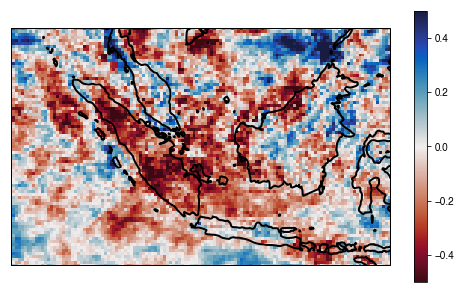

In [120]:
map_proj = cartopy.crs.PlateCarree()
data_proj = cartopy.crs.PlateCarree()

clevels = numpy.arange(-0.5,0.51,0.01)

fig = mp.figure(figsize=(8.5,5))
ax = fig.add_subplot(111, projection=map_proj)
# plot = ax.contourf(lon[lon_indices],lat[lat_indices],trmm_aso_stdev_linregress_rvals.T,\
#             transform=data_proj,extend='both',cmap=cmocean.cm.balance_r,levels=clevels)
plot = ax.pcolormesh(lon[lon_indices],lat[lat_indices],trmm_aso_stdev_linregress_rvals.T,\
            transform=data_proj,vmin=clevels.min(),vmax=clevels.max(),cmap=cmocean.cm.balance_r)
ax.coastlines(resolution='50m', lw=2)

#ax.set_extent([90,155,-20,20])
ax.set_extent([90,122,-10,10])
fig.colorbar(plot)

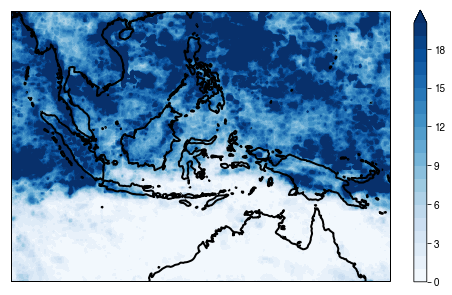

In [90]:
map_proj = cartopy.crs.PlateCarree()
data_proj = cartopy.crs.PlateCarree()

clevels = numpy.arange(-0,20.1,1)

fig = mp.figure(figsize=(8.5,5))
ax = fig.add_subplot(111, projection=map_proj)
plot = ax.contourf(lon[lon_indices],lat[lat_indices],trmm_annual_aso_stdev[5,:,:].T,\
            transform=data_proj,extend='max',cmap='Blues',levels=clevels)
ax.coastlines(resolution='50m', lw=2)

ax.set_extent([90,155,-20,20])
fig.colorbar(plot)

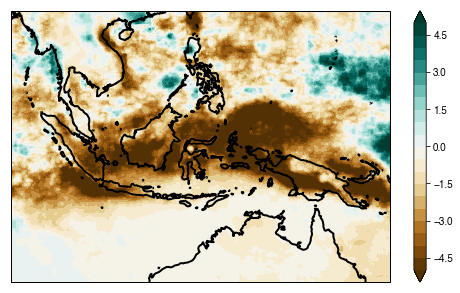

In [58]:
map_proj = cartopy.crs.PlateCarree()
data_proj = cartopy.crs.PlateCarree()

clevels = numpy.arange(-5,5.1,0.5)

fig = mp.figure(figsize=(8.5,5))
ax = fig.add_subplot(111, projection=map_proj)
plot = ax.contourf(lon[lon_indices],lat[lat_indices],trmm_elnino_months_mean.T-trmm_lanina_months_mean.T,\
            transform=data_proj,extend='both',cmap='BrBG',levels=clevels)
ax.coastlines(resolution='50m', lw=2)

ax.set_extent([90,155,-20,20])
fig.colorbar(plot)

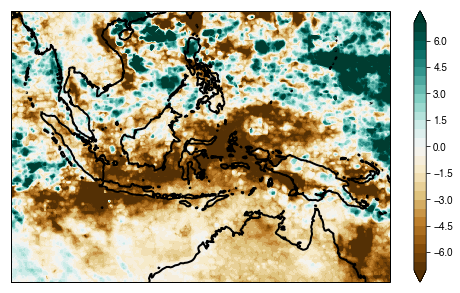

In [59]:
map_proj = cartopy.crs.PlateCarree()
data_proj = cartopy.crs.PlateCarree()

clevels = numpy.arange(-7,7.1,0.5)

fig = mp.figure(figsize=(8.5,5))
ax = fig.add_subplot(111, projection=map_proj)
plot = ax.contourf(lon[lon_indices],lat[lat_indices],trmm_elnino_months_stdev.T-trmm_lanina_months_stdev.T,\
            transform=data_proj,extend='both',cmap='BrBG',levels=clevels)
ax.coastlines(resolution='50m', lw=2)

ax.set_extent([90,155,-20,20])
fig.colorbar(plot)

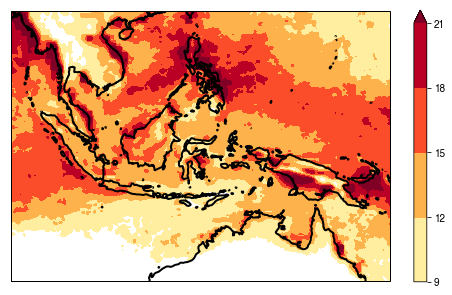

In [29]:
map_proj = cartopy.crs.PlateCarree()
data_proj = cartopy.crs.PlateCarree()

clevels = numpy.arange(9,23.1,3)

fig = mp.figure(figsize=(8.5,5))
ax = fig.add_subplot(111, projection=map_proj)
plot = ax.contourf(lon[lon_indices],lat[lat_indices],trmm_stdev.T,\
            transform=data_proj,extend='max',cmap='YlOrRd',levels=clevels)
ax.coastlines(resolution='50m', lw=2)

ax.set_extent([90,155,-20,20])
fig.colorbar(plot)